# Programming Assignment 1

In [1]:
# Setup and load starter codes
import argparse

import numpy as np

import data
import network
import math

from matplotlib import pyplot as plt

np.random.seed(seed = 100) # fix random seed to make things reproducible

## Loading Data

In [2]:
train_val = data.load_data()
train_val[0].shape, train_val[1].shape

((60000, 784), (60000,))

In [3]:
test = data.load_data(train=False)
test[0].shape, test[1].shape

((10000, 784), (10000,))

## Data EDA

### Training

In [4]:
# Classes distribution
c_counts = np.zeros(10)
for c in train_val[1]:
    c_counts[c] += 1
c_counts

array([6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000.,
       6000.])

### Test

In [5]:
# Classes distribution
c_counts = np.zeros(10)
for c in test[1]:
    c_counts[c] += 1
c_counts

array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000.])

## Logistic Regression

### Pre-process
Get two sets of data for the logistic regression

In [6]:
# filter dataset before start
def set1_filter(dataset):
    # 0 or 6
    idx = []
    img, lab = dataset
    for i in range(len(lab)):
        if lab[i] == 0 or lab[i] == 6:
            idx.append(i)

    return img[idx], lab[idx]

def set2_filter(dataset):
    # 2 or 6
    idx = []
    img, lab = dataset
    for i in range(len(lab)):
        if lab[i] == 2 or lab[i] == 6:
            idx.append(i)

    return img[idx], lab[idx]

In [7]:
train_set1 = set1_filter(train_val)
print(train_set1[0].shape, train_set1[1].shape)
train_set2 = set2_filter(train_val)
print(train_set2[0].shape, train_set2[1].shape)

(12000, 784) (12000,)
(12000, 784) (12000,)


In [8]:
test_set1 = set1_filter(test)
print(test_set1[0].shape, test_set1[1].shape)
test_set2 = set2_filter(test)
print(test_set2[0].shape, test_set2[1].shape)

(2000, 784) (2000,)
(2000, 784) (2000,)


In [9]:
# put data into X and y respectively
train_X_set1, train_y_set1 = train_set1[0], train_set1[1]
train_X_set2, train_y_set2 = train_set2[0], train_set2[1]
test_X_set1, test_y_set1 = test_set1[0], test_set1[1]
test_X_set2, test_y_set2 = test_set2[0], test_set2[1]

In [10]:
# normalize X
train_X_set1 = data.min_max_normalize(train_X_set1)
train_X_set2 = data.min_max_normalize(train_X_set2)
test_X_set1 = data.min_max_normalize(test_X_set1)
test_X_set2 = data.min_max_normalize(test_X_set2)

In [11]:
# change labels for logistic regression
# for set 1, set 6 to be 1, and 0 to be 0
train_y_set1 = np.where(train_y_set1 == 6, 1, train_y_set1)

test_y_set1 = np.where(test_y_set1 == 6, 1, test_y_set1)

# for set 2, set 6 to be 1, and 2 to be 0
train_y_set2 = np.where(train_y_set2 == 6, 1, train_y_set2)
train_y_set2 = np.where(train_y_set2 == 2, 0, train_y_set2)

test_y_set2 = np.where(test_y_set2 == 6, 1, test_y_set2)
test_y_set2 = np.where(test_y_set2 == 2, 0, test_y_set2)

In [12]:
# merge things back
train_val_set1 = (train_X_set1, train_y_set1)
train_val_set2 = (train_X_set2, train_y_set2)
test_set1 = (test_X_set1, test_y_set1)
test_set2 = (test_X_set2, test_y_set2)

### Default Setting

In [13]:
# training and validation
def cross_validation(dataset, hyperparameters, activation, loss, out_dim):
    regressor = network.Network(hyperparameters, activation, loss, out_dim)

    losses_train = []
    losses_val = []

    accs_val = []

    best_weights = regressor.weights # initialize it to the current weights
    k = 0

    for train, val in data.generate_k_fold_set(dataset, k=hyperparameters["k_folds"]):
        for epoch in range(hyperparameters["epochs"]):
            loss_train = [] # training loss per epoch including all mini-batchs
            for minibatch in data.generate_minibatches(train, batch_size=hyperparameters["batch_size"]): # SGD
                loss_batch, _ = regressor.train(minibatch)
                loss_train.append(loss_batch)

            loss_val, acc_val = regressor.test(val) # use the current weight to get a validation loss

            loss_train = np.mean(loss_train) # average all mini-batchs
            losses_train.append(loss_train)
            losses_val.append(loss_val)
            accs_val.append(acc_val)

            if loss_val <= losses_val[-1]: # if the val loss is less than the previous
                best_weights = regressor.weights # update the weights
            else: # if the val loss goes up
                break # stop training

        k += 1
        print("k", k, "done")

    regressor.weights = best_weights # after training, assign the best weight to the regressor

    plt.plot(losses_train)
    plt.plot(losses_val)

    return regressor

k 1 done
k 2 done
k 3 done
k 4 done
k 5 done
k 6 done
k 7 done
k 8 done
k 9 done
k 10 done


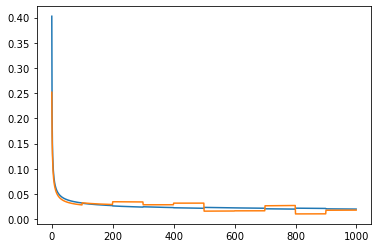

In [14]:
hyperparameters = {"epochs": 100,
                   "batch_size": 64,
                   "learning_rate": 0.001,
                   "k_folds": 10}

cross_validation(train_val_set1, hyperparameters, network.softmax, network.multiclass_cross_entropy, 2)